In [3]:
from __future__ import division # division without truncating decimals 
import pandas as pd # data manipulation library
import numpy as np # numerical computation library
import datetime as dt 

import matplotlib.pyplot as plt # plotting library
from matplotlib import cm # color maps for plotting
plt.style.use('ggplot') # use the ggplot plotting style

%matplotlib inline

pd.options.mode.chained_assignment = None

def predictPlay():
#reading the csv file
    nfl = pd.read_csv('reg_pbp_2018.csv', low_memory=False)
    #nfl.head()
    #changing the dates to a date format
    nfl['game_date'] = pd.to_datetime(nfl['game_date'])
    #nfl['game_date'].head()
    
    print("Enter your team's 2 or 3 letter initials (i.e. BAL for Baltimore Ravens):")
    team = input()
    
    teamOff = nfl[ (nfl["posteam"] == team)]
    teamDef = nfl[ (nfl["defteam"] == team)]
    
    #ravens rushing
    teamRush = teamOff[(teamOff['rush_attempt'] == 1)]

    runAtt = teamRush.groupby(['run_location', 'run_gap']).size()
    #print(LRunAtt)
    runYds = teamRush.groupby(['run_location', 'run_gap']).yards_gained.sum()
    #print(LRunYds)

    YPC = runYds/runAtt
    #print(LYPC)
    
    YPCTot = 0
    for i in range(len(YPC)):
        YPCTot+=YPC[i]
    YPCTot/=len(YPC)
    
    
    #ravens rush defense
    oppRush = teamDef[(teamDef['rush_attempt'] == 1)]

    oppRAtt = teamDef.groupby(['run_location', 'run_gap']).size()
    #print(LOppRAtt)
    oppRYds = teamDef.groupby(['run_location', 'run_gap']).yards_gained.sum()
    #print(LOppRYds)
    

    oppYPC = oppRYds/oppRAtt
    #print(LOppYPC)
   

    oppYPCTot = 0
    for i in range(len(oppYPC)):
        oppYPCTot+=oppYPC[i]
    oppYPCTot/=len(oppYPC)

    
    
    #Ravens probabilities
    rush1st = teamRush.groupby(['run_location', 'run_gap']).first_down_rush.sum()
    rush1st /= runAtt
    #print(LRush1st)

    rushTD = teamRush.groupby(['run_location', 'run_gap']).touchdown.sum()
    rushTD/=runAtt
    #print(LRushTD)

    
    #Get an accuracy score for each row based on the user's provided input
    print("Enter Score difference (negative if you're losing, positive if you're winning):")
    teamScore = input()
    teamOff['accuracy'] = np.where((teamOff['score_differential'] - int(teamScore)) == 0, 3, 0)
    teamOff['accuracy'][teamOff['score_differential'] == int(teamScore)] = 3
    teamOff['accuracy'][(teamOff['score_differential'] - int(teamScore) < 7) & (teamOff['score_differential'] - int(teamScore) > 0)] = 1
    teamOff['accuracy'][(teamOff['score_differential'] - int(teamScore) > -7) & (teamOff['score_differential'] - int(teamScore) < 0)] = 1
    #lamarOff['accuracy']

    print("Enter what Quarter it is:")
    quarter = input()
    teamOff['accuracy'][teamOff['qtr'] == int(quarter)] += 3
    teamOff['accuracy'][teamOff['qtr'] - int(quarter) == 1 ] += 1
    teamOff['accuracy'][teamOff['qtr'] + int(quarter) == 1 ] += 1
    #lamarOff['accuracy']

    print("Enter the minutes left in the quarter:")
    timeLeft = input()
    teamOff['accuracy'][teamOff['game_seconds_remaining']/60 == int(timeLeft)] += 3
    teamOff['accuracy'][((teamOff['game_seconds_remaining']/60) - int(timeLeft) > -3) & ((teamOff['game_seconds_remaining']/60) - int(timeLeft) < 0)] += 1
    teamOff['accuracy'][((teamOff['game_seconds_remaining']/60) - int(timeLeft) < 3) & ((teamOff['game_seconds_remaining']/60) - int(timeLeft) > 0)] += 1
    #lamarOff['accuracy']

    print("Enter what down it is:")
    down = input()
    teamOff['accuracy'][teamOff['down'] == int(down)] += 3
    teamOff['accuracy'][(teamOff['down'] - int(down) == -1)] += 1
    teamOff['accuracy'][(teamOff['down'] - int(down) == 1)] += 1
    #lamarOff['accuracy']

    print("Enter the yards to go to the first down:")
    yardsToGo = input()
    teamOff['accuracy'][teamOff['ydstogo'] == int(yardsToGo)] += 3
    teamOff['accuracy'][(teamOff['ydstogo'] - int(yardsToGo) > -3) & (nfl['down'] - int(down) < 0)] += 1
    teamOff['accuracy'][(teamOff['ydstogo'] - int(yardsToGo) < 3) & (nfl['down'] - int(down) > 0)] += 1
    #lamarOff['accuracy']

    print("Enter the yard line (out of 100 if it's in the opponents territory (so opposing 40 yard line means 60 yard line)):")
    yardLine = input()
    teamOff['accuracy'][teamOff['yardline_100'] == int(yardLine)] += 3
    teamOff['accuracy'][(teamOff['yardline_100'] - int(yardLine) >= -10) & (teamOff['yardline_100'] - int(yardLine) < 0)] += 2
    teamOff['accuracy'][(teamOff['yardline_100'] - int(yardLine) <= 10) & (teamOff['yardline_100'] - int(yardLine) > 0)] += 2
    teamOff['accuracy'][(teamOff['yardline_100'] - int(yardLine) >= -20) & (teamOff['yardline_100'] - int(yardLine) < 10)] += 2
    teamOff['accuracy'][(teamOff['yardline_100'] - int(yardLine) <= 20) & (teamOff['yardline_100'] - int(yardLine) > 0)] += 2
    #lamarOff['accuracy']

    #if a play has a similarity score of at least 50% it'll include the data in the prediction
    max = 0
    i=0
    df = pd.DataFrame()
    select_indices = list(np.where(teamOff['accuracy'] >= 9))
    df = teamOff.iloc[(select_indices)[0]]
    
    #print("Team Rush Attemps In: ")
    RunAtt = df.groupby(['run_location', 'run_gap']).size()
    #print(RunAtt)

    #print("\n\n1st down % chance:")
    Rush1st = df.groupby(['run_location', 'run_gap']).first_down_rush.sum()
    Rush1st/=RunAtt
    #print(Rush1st)

    #print("\n\nTouchdown % chance:")
    RushTD = df.groupby(['run_location', 'run_gap']).touchdown.sum()
    RushTD/=RunAtt
    #print(RushTD)

    #print("\n\nAvg Yards")
    RYdsNet = df.groupby(['run_location', 'run_gap']).yards_gained.sum()
    RYdsNet/=RunAtt
    #print(YdsNet)
    
    #print("Team Pass Attemps In: ")
    PassAtt = df.groupby(['pass_length', 'pass_location']).size()
    #print(PassAtt)

    #print("\n\n1st down % chance:")
    Pass1st = df.groupby(['pass_length', 'pass_location']).first_down_pass.sum()
    Pass1st/=PassAtt
    #print(Rush1st)

    #print("\n\nTouchdown % chance:")
    PassTD = df.groupby(['pass_length', 'pass_location']).touchdown.sum()
    PassTD/=PassAtt
    #print(RushTD)

    #print("\n\nAvg Yards")
    PYdsNet = df.groupby(['pass_length', 'pass_location']).yards_gained.sum()
    PYdsNet/=PassAtt
    #print(YdsNet)

    #how to get bar graph
    
    mycolors = ['#A6192E', '#85714D']
    def switch_demo(argument):
        switcher = {
            'ARI': ['#97233F', '#000000'],
            'ATL': ['#A71930', '#000000'],
            'BAL': ['#241773', '#9E7C0C'],
            'BUF': ['#00338D', '#C60C30'],
            'CAR': ['#0085CA', '#101820'],
            'CHI': ['#0B162A', '#C83803'],
            'CIN': ['#FB4F14', '#000000'],
            'CLE': ['#311D00', '#FF3C00'],
            'DAL': ['#003594', '#041E42'],
            'DEN': ['#FB4F14', '#002244'],
            'DET': ['#0076B6', '#B0B7BC'],
            'GB':  ['#203731', '#FFB612'],
            'HOU': ['#03202F', '#A71930'],
            'IND': ['#002C5F', '#A2AAAD'],
            'JAX': ['#006778', '#D7A22A'],
            'KC': ['#E31837', '#FFB81C'],
            'LAC': ['#002A5E', '#FFC20E'],
            'LAR': ['#002244', '#866D4B'],
            'MIA': ['#008E97', '#F26A24'],
            'MIN': ['#4F2683', '#FFC62F'],
            'NE': ['#002244', '#C60C30'],
            'NO': ['#D3BC8D', '#101820'],
            'NYG': ['#0B2265', '#A71930'],
            'NYJ': ['#003F2D', '#FFFFFF'],
            'OAK': ['#000000', '#A5ACAF'],
            'PHI': ['#004C54', '#A5ACAF'],
            'PIT': ['#FFB612', '#101820'],
            'SEA': ['#A6192E', '#85714D'],
            'SF': ['#AA0000', '#B3995D'],
            'TB': ['#D50A0A', '#FF7900'],
            'TEN': ['#0C2340', '#418FDE'],
            'WAS': ['#773141', '#FFB612'],
        }
        return switcher.get(argument, "Invalid team")

    mycolors = switch_demo(team)
    
    def plotDF(df, title, xlab, ylab):
        fig, ax = plt.subplots(figsize=(8, 6), dpi = 72) # Get access to the figure and axes to modify their attributes later
        
        ax.set_title(team + title, fontsize = 18) # Chart title
        ax.set_xlabel(xlab, fontsize = 15) # X-axis label
        ax.set_ylabel(ylab, fontsize = 15) # Y-axis label
        plt.xticks(fontsize = 9)
        plt.yticks(fontsize = 9)
        df.plot(kind='bar', alpha = 0.9, rot=0, color = mycolors)
    
    plotDF(Rush1st, " Probability of getting a Rushing 1st down", "Rush Direction", "Probability")
    plotDF(RushTD, " Probability of getting a Rushing Touchdown", "Rush Direction", "Probability")
    plotDF(RYdsNet, " Avg Rush Yards", "Rush Direction", "Yards")
    plotDF(Pass1st, " Probability of getting a Passing 1st down", "Pass Direction", "Probability")
    plotDF(PassTD, " Probability of getting a Passing touchdown", "Pass Direction", "Probability")
    plotDF(PYdsNet, " Avg Pass Yards", "Pass Direction", "Yards")
    
   

Enter your team's 2 or 3 letter initials (i.e. BAL for Baltimore Ravens):
BAL
Enter Score difference (negative if you're losing, positive if you're winning):
-7
Enter what Quarter it is:
4
Enter the minutes left in the quarter:
5
Enter what down it is:
2
Enter the yards to go to the first down:
10
Enter the yard line (out of 100 if it's in the opponents territory (so opposing 40 yard line means 60 yard line)):
80


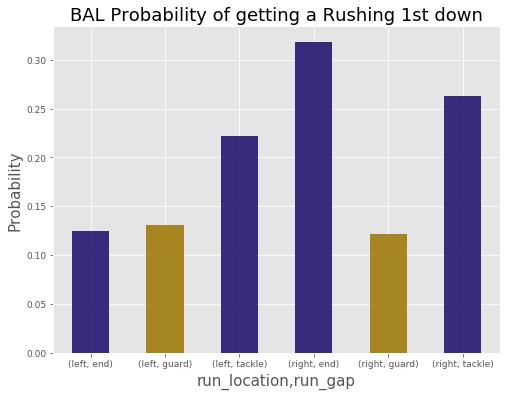

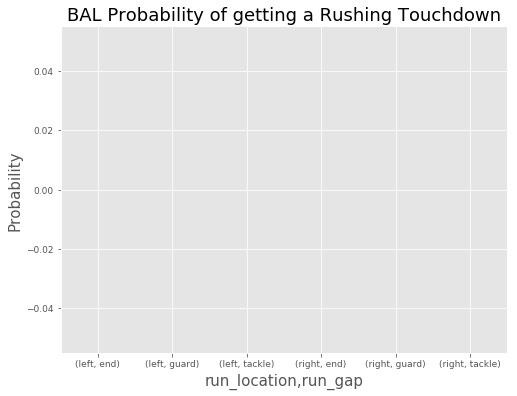

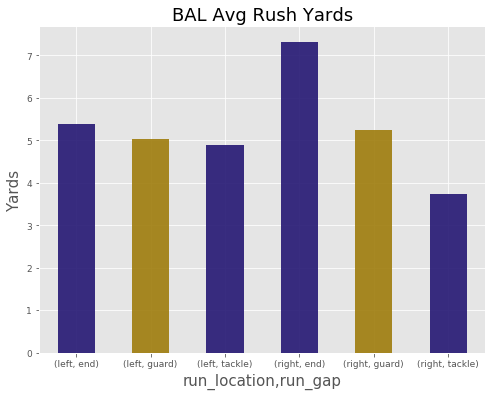

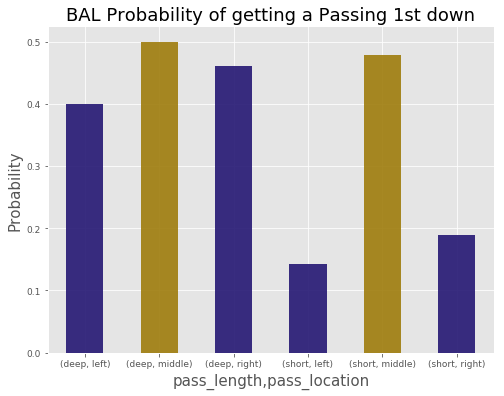

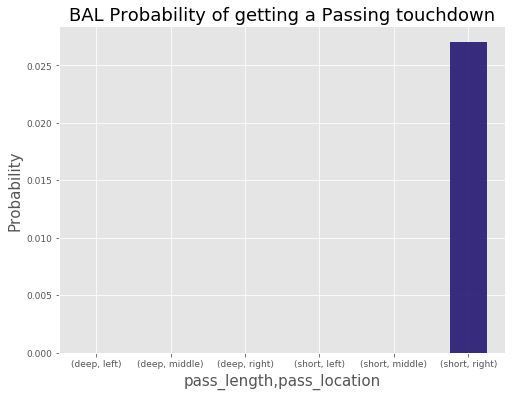

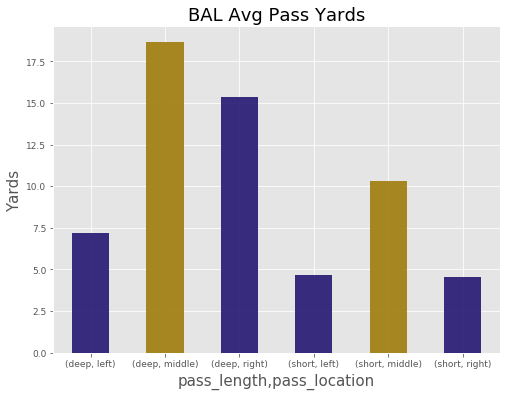

In [4]:
predictPlay()